____
__Universidad de San Andrés__<br/>
__Visión Artificial__<br/>
__Trabajo Práctico 1: Panorámica__<br/>
__Martin Bianchi y Federico Gutman__
____

### Importamos las librerías necesarias

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Visualizamos las imágenes

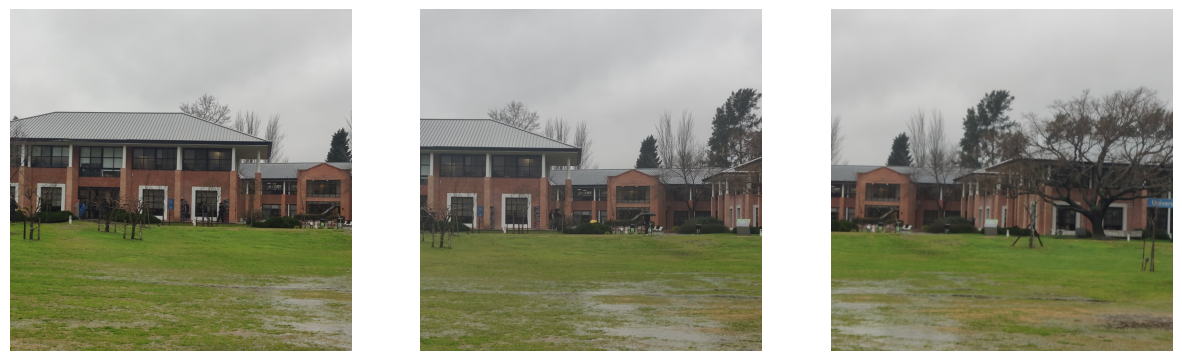

In [2]:
# cargo las imágenes (open cv las carga en bgr)
udesa_left = cv2.imread("img/udesa_0.jpg", flags=cv2.IMREAD_COLOR)
udesa_center = cv2.imread("img/udesa_1.jpg", flags=cv2.IMREAD_COLOR)
udesa_right = cv2.imread("img/udesa_2.jpg", flags=cv2.IMREAD_COLOR)

# convierto a rgb
udesa_left = cv2.cvtColor(udesa_left, cv2.COLOR_BGR2RGB)
udesa_center = cv2.cvtColor(udesa_center, cv2.COLOR_BGR2RGB)
udesa_right = cv2.cvtColor(udesa_right, cv2.COLOR_BGR2RGB)

# muestro las imágenes
fig, ax = plt.subplots(1, 3, figsize=(15, 10))
ax[0].imshow(udesa_left)
ax[0].axis('off')

ax[1].imshow(udesa_center)
ax[1].axis('off')

ax[2].imshow(udesa_right)
ax[2].axis('off')
plt.show()

### Seguimos el pipeline propuesto

#### Paso 1: Detección de características visuales

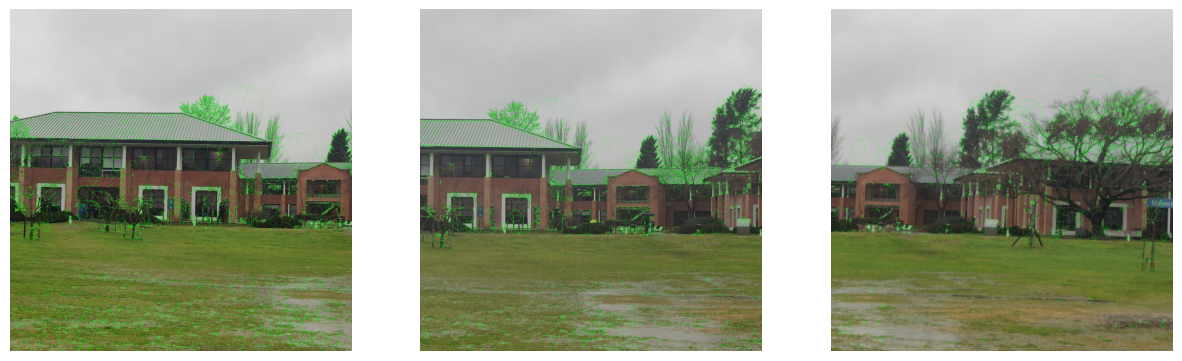

In [3]:
# se pueden usar: sift, surf, akaze, orb
# pruebo con sift

sift = cv2.SIFT_create()

# detecto keypoints y computo descriptores
keypoints_left, descriptors_left = sift.detectAndCompute(udesa_left, None)
keypoints_center, descriptors_center = sift.detectAndCompute(udesa_center, None)
keypoints_right, descriptors_right = sift.detectAndCompute(udesa_right, None)

# dibujo keypoints
img_keypoints_left = cv2.drawKeypoints(udesa_left, keypoints_left, None, color=(0,255,0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img_keypoints_center = cv2.drawKeypoints(udesa_center, keypoints_center, None, color=(0,255,0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img_keypoints_right = cv2.drawKeypoints(udesa_right, keypoints_right, None, color=(0,255,0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)   

# muestro las imágenes con keypoints
fig, ax = plt.subplots(1, 3, figsize=(15, 10))
ax[0].imshow(img_keypoints_left)
ax[0].axis('off')

ax[1].imshow(img_keypoints_center)
ax[1].axis('off')

ax[2].imshow(img_keypoints_right)
ax[2].axis('off')
plt.show()


#### Paso 2: Supresión de No Máxima Adaptativa

ANMS -> left:  800 / 22176
ANMS -> center:800 / 14926
ANMS -> right: 800 / 5308


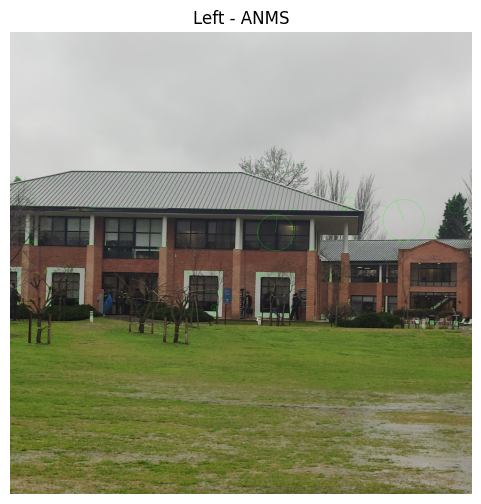

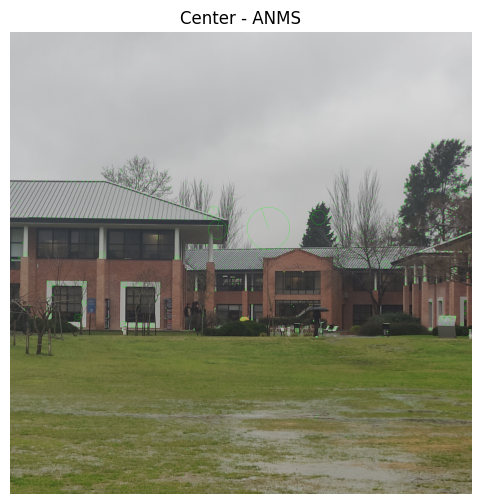

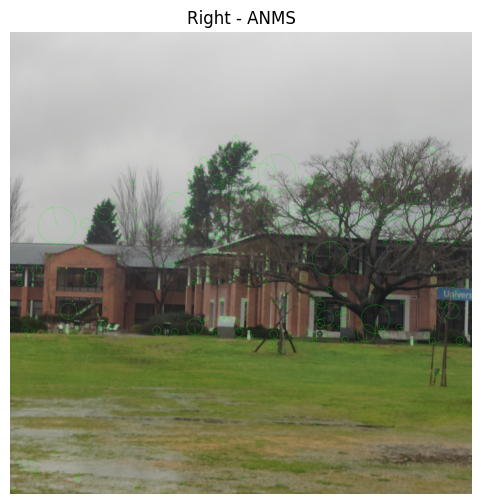

In [4]:
import numpy as np
import cv2

def anms(keypoints, descriptors, num_points, c_robust=0.9, pre_k=None):
    """
    Selecciona 'num_points' keypoints bien distribuidos usando ANMS (Adaptive Non-Maximal Suppression).

    Parámetros:
      - keypoints: lista de cv2.KeyPoint, tal como sale de detectAndCompute.
      - descriptors: ndarray (N x D) alineado con 'keypoints'.
      - num_points: cantidad de puntos deseados tras ANMS.
      - c_robust: factor de “significativamente más fuerte” (0.9–1.0 suele andar bien).
      - pre_k: si se pasa un int, primero se queda con los 'pre_k' puntos de mayor respuesta
               para acelerar (recomendado si N es muy grande).

    Returns:
      - kps_sel: lista de KeyPoint seleccionados (ordenados por radio descendente).
      - desc_sel: ndarray (M x D) con descriptores seleccionados; M = min(num_points, len(keypoints)).
      - idx_sel: índices de los puntos seleccionados respecto del arreglo ORIGINAL.
      - radii_sel: radios de supresión de los seleccionados (útil para debug).
    """
    assert descriptors is None or len(keypoints) == len(descriptors), "kp y desc deben alinear"

    N = len(keypoints)
    if N == 0:
        return [], np.empty((0, 0)), [], np.array([])

    # Ordenar por respuesta desc y quedarnos opcionalmente con top-k
    order = np.argsort([-kp.response for kp in keypoints])
    if pre_k is not None and pre_k < len(order):
        order = order[:pre_k]

    kps_sorted = [keypoints[i] for i in order]
    desc_sorted = None if descriptors is None else descriptors[order]

    # Precomputar posiciones (x, y) y respuestas
    pts = np.array([kp.pt for kp in kps_sorted], dtype=np.float32)
    resp = np.array([kp.response for kp in kps_sorted], dtype=np.float32)

    # Radios ANMS: distancia al vecino "significativamente más fuerte"
    n = len(kps_sorted)
    radii = np.full(n, np.inf, dtype=np.float32)

    # O(n^2) simple y claro (suficiente para cientos/miles de puntos; para muchísimos, usar pre_k)
    for i in range(n):
        # candidatos más fuertes que cumplan r_j > c_robust * r_i
        stronger = np.where(resp[:i] > c_robust * resp[i])[0]
        if stronger.size > 0:
            dists = np.linalg.norm(pts[i] - pts[stronger], axis=1)
            radii[i] = dists.min()
        # si no hay más fuertes, radii[i] queda en inf y eso lo prioriza (está bien)

    # Elegir los num_points con mayor radio
    keep = np.argsort(-radii)[:min(num_points, n)]
    keep = keep[np.argsort(-radii[keep])]  # ordenar seleccionados por radio desc para reproducibilidad

    kps_sel = [kps_sorted[i] for i in keep]
    desc_sel = None if desc_sorted is None else desc_sorted[keep]

    # Mapear índices seleccionados al arreglo ORIGINAL
    idx_sel = [int(order[i]) for i in keep]
    radii_sel = radii[keep]

    return kps_sel, desc_sel, idx_sel, radii_sel


# ===== Ejemplo de uso con tus imágenes (izq, centro, der) =====
# Elegí una cuota razonable. Podés empezar con 800 y ajustar.
N = 800
c = 0.9
pre_k = 3000  # opcional: acelerar si SIFT te dio muchísimos puntos

kpsL_anms, descL_anms, idxL, radL = anms(keypoints_left,  descriptors_left,  N, c_robust=c, pre_k=pre_k)
kpsC_anms, descC_anms, idxC, radC = anms(keypoints_center,descriptors_center, N, c_robust=c, pre_k=pre_k)
kpsR_anms, descR_anms, idxR, radR = anms(keypoints_right, descriptors_right, N, c_robust=c, pre_k=pre_k)

print(f"ANMS -> left:  {len(kpsL_anms)} / {len(keypoints_left)}")
print(f"ANMS -> center:{len(kpsC_anms)} / {len(keypoints_center)}")
print(f"ANMS -> right: {len(kpsR_anms)} / {len(keypoints_right)}")

# Visual rápido: dibujo sólo los seleccionados (convierte a RGB para que no se vea "verdoso" en matplotlib)
import numpy as np
import cv2
import matplotlib.pyplot as plt

def draw_keypoints_single(img, kps, title="", color=(0,255,0), source='cv2'):
    """
    Muestra una imagen con keypoints en una figura individual,
    manejando correctamente BGR/RGB según el origen.

    Parámetros:
      - img: imagen (BGR si source='cv2', RGB si source='rgb').
      - kps: lista de cv2.KeyPoint.
      - title: título de la figura.
      - color: color de los keypoints (en BGR, como usa OpenCV).
      - source: 'cv2' si img viene de cv2.imread (BGR),
                'rgb' si img viene de plt.imread/PIL (RGB).
    """
    # Asegurar tipo uint8 si viniera como float [0,1] (típico de plt.imread en PNG)
    if img.dtype != np.uint8:
        img8 = (np.clip(img, 0, 1) * 255).astype(np.uint8)
    else:
        img8 = img

    if source == 'cv2':
        # Ya está en BGR → dibujar y convertir a RGB para mostrar
        img_draw = cv2.drawKeypoints(img8, kps, None, color=color,
                                     flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        img_show = cv2.cvtColor(img_draw, cv2.COLOR_BGR2RGB)
    else:
        # Viene en RGB → convertir a BGR para dibujar, y volver a RGB para mostrar
        img_bgr   = cv2.cvtColor(img8, cv2.COLOR_RGB2BGR)
        img_draw  = cv2.drawKeypoints(img_bgr, kps, None, color=color,
                                      flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        img_show  = cv2.cvtColor(img_draw, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(6,6))
    plt.imshow(img_show)
    plt.title(title)
    plt.axis('off')
    plt.show()

#Si las cargaste con plt.imread / PIL:
draw_keypoints_single(udesa_left,   kpsL_anms, title="Left - ANMS",   source='rgb')
draw_keypoints_single(udesa_center, kpsC_anms, title="Center - ANMS", source='rgb')
draw_keypoints_single(udesa_right,  kpsR_anms, title="Right - ANMS",  source='rgb')


#### Paso 3: Descripción de las características

Left–Center -> Lowe+Cross: 93 matches
Right–Center -> Lowe+Cross: 29 matches


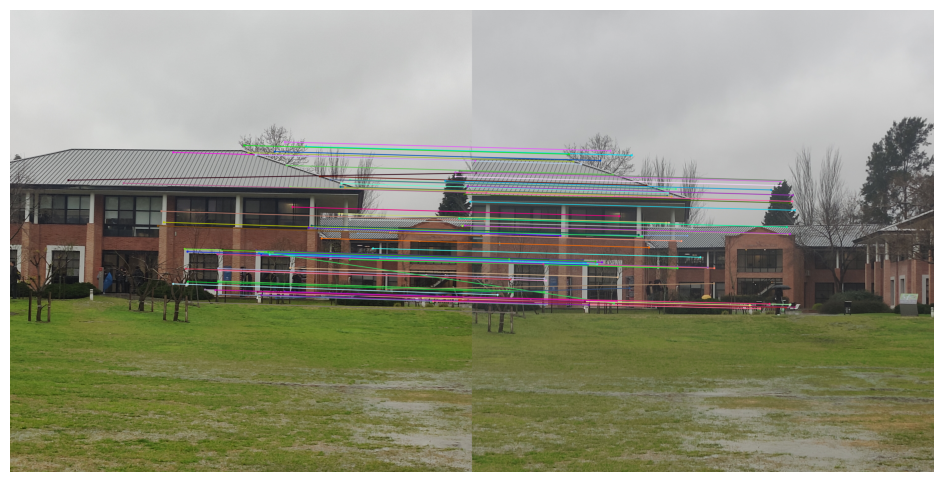

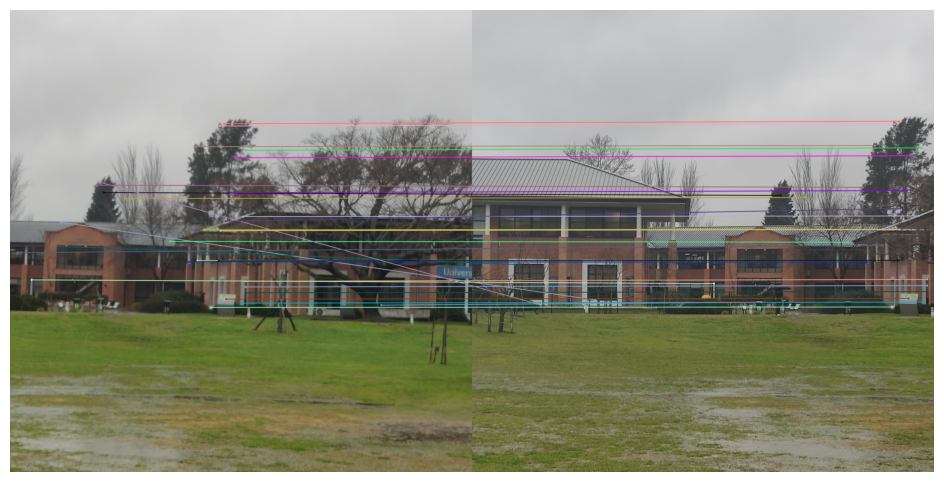

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- util mínimo para mostrar matches cuando las imágenes están en RGB (plt/PIL) ---
def _u8(img):
    return (img*255).astype(np.uint8) if img.dtype!=np.uint8 else img

def show_matches_rgb(img1_rgb, kps1, img2_rgb, kps2, matches, max_show=60, title=""):
    img1_u8 = _u8(img1_rgb); img2_u8 = _u8(img2_rgb)
    draw = cv2.drawMatches(cv2.cvtColor(img1_u8, cv2.COLOR_RGB2BGR), kps1,
                           cv2.cvtColor(img2_u8, cv2.COLOR_RGB2BGR), kps2,
                           matches[:max_show], None,
                           flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(10,6))
    plt.imshow(cv2.cvtColor(draw, cv2.COLOR_BGR2RGB))
    plt.title(title); plt.axis('off'); plt.show()

# --- elegir norma según descriptor (SIFT -> L2, ORB/BRIEF -> Hamming) ---
def _norm_for(desc):
    return cv2.NORM_L2 if desc.dtype==np.float32 else cv2.NORM_HAMMING

# 1) Lowe ratio
def match_lowe(kps1, desc1, kps2, desc2, ratio=0.75):
    """
    Matchea con kNN(k=2) + filtro de Lowe.
    Devuelve (matches_ordenados, pts1, pts2).
    """
    if desc1 is None or desc2 is None or len(desc1)==0 or len(desc2)==0:
        return [], np.empty((0,2), np.float32), np.empty((0,2), np.float32)

    matcher = cv2.BFMatcher(_norm_for(desc1), crossCheck=False)
    knn = matcher.knnMatch(desc1, desc2, k=2)

    good = []
    for pair in knn:
        if len(pair)<2: continue
        m, n = pair
        if m.distance < ratio * n.distance:
            good.append(m)

    good.sort(key=lambda x: x.distance)
    pts1 = np.array([kps1[m.queryIdx].pt for m in good], np.float32)
    pts2 = np.array([kps2[m.trainIdx].pt for m in good], np.float32)
    return good, pts1, pts2

# 2) Cross-check (mejor vecino recíproco)
def match_crosscheck(kps1, desc1, kps2, desc2):
    """
    Matchea con mejor vecino y verificación cruzada (mutua).
    Devuelve (matches_ordenados, pts1, pts2).
    """
    if desc1 is None or desc2 is None or len(desc1)==0 or len(desc2)==0:
        return [], np.empty((0,2), np.float32), np.empty((0,2), np.float32)

    # BF con crossCheck=True ya hace verificación recíproca
    matcher = cv2.BFMatcher(_norm_for(desc1), crossCheck=True)
    matches = matcher.match(desc1, desc2)
    matches.sort(key=lambda x: x.distance)

    pts1 = np.array([kps1[m.queryIdx].pt for m in matches], np.float32)
    pts2 = np.array([kps2[m.trainIdx].pt for m in matches], np.float32)
    return matches, pts1, pts2

# 3) Combinado: Lowe primero y después verificación cruzada manual sobre los mejores vecinos
def match_lowe_cross(kps1, desc1, kps2, desc2, ratio=0.75):
    """
    Combina Lowe + verificación cruzada (mutua).
    Devuelve (matches_ordenados, pts1, pts2).
    """
    if desc1 is None or desc2 is None or len(desc1)==0 or len(desc2)==0:
        return [], np.empty((0,2), np.float32), np.empty((0,2), np.float32)

    norm = _norm_for(desc1)
    # Lowe
    bf12 = cv2.BFMatcher(norm, crossCheck=False)
    knn12 = bf12.knnMatch(desc1, desc2, k=2)
    cand = []
    for pair in knn12:
        if len(pair)<2: continue
        m, n = pair
        if m.distance < ratio * n.distance:
            cand.append(m)

    # mapa mejor vecino 2->1
    bf21 = cv2.BFMatcher(norm, crossCheck=False)
    knn21 = bf21.knnMatch(desc2, desc1, k=1)
    best21 = {m.queryIdx: m.trainIdx for [m] in knn21}

    # verificación recíproca sobre los candidatos de Lowe
    good = [m for m in cand if best21.get(m.trainIdx, -1) == m.queryIdx]
    good.sort(key=lambda x: x.distance)

    pts1 = np.array([kps1[m.queryIdx].pt for m in good], np.float32)
    pts2 = np.array([kps2[m.trainIdx].pt for m in good], np.float32)
    return good, pts1, pts2

import cv2
import numpy as np
import matplotlib.pyplot as plt

def draw_matches_thick_rgb(img1_rgb, kps1, img2_rgb, kps2, matches,
                           max_show=60, thickness=3, radius=6):
    """
    Dibuja matches con control de grosor de líneas y tamaño de puntos.
    - img*_rgb: imágenes en RGB (plt/PIL)
    - kps*: listas de cv2.KeyPoint
    - matches: lista de cv2.DMatch
    """
    # asegurar uint8
    img1 = (img1_rgb*255).astype(np.uint8) if img1_rgb.dtype!=np.uint8 else img1_rgb
    img2 = (img2_rgb*255).astype(np.uint8) if img2_rgb.dtype!=np.uint8 else img2_rgb

    # convertir a BGR para dibujar con OpenCV
    im1 = cv2.cvtColor(img1, cv2.COLOR_RGB2BGR)
    im2 = cv2.cvtColor(img2, cv2.COLOR_RGB2BGR)

    # crear lienzo lado a lado
    h1, w1 = im1.shape[:2]
    h2, w2 = im2.shape[:2]
    H = max(h1, h2)
    canvas = np.zeros((H, w1 + w2, 3), dtype=np.uint8)
    canvas[:h1, :w1] = im1
    canvas[:h2, w1:w1+w2] = im2

    # dibujar
    rng = np.random.default_rng(0)  # colores reproducibles
    for m in matches[:max_show]:
        p1 = tuple(int(v) for v in kps1[m.queryIdx].pt)
        p2 = tuple(int(v) for v in kps2[m.trainIdx].pt)
        p2_off = (p2[0] + w1, p2[1])  # offset a la derecha

        color = tuple(int(c) for c in rng.integers(0, 255, size=3))  # BGR aleatorio

        # puntos gordos
        cv2.circle(canvas, p1, radius, color, -1)
        cv2.circle(canvas, p2_off, radius, color, -1)
        # línea gruesa
        cv2.line(canvas, p1, p2_off, color, thickness, lineType=cv2.LINE_AA)

    # mostrar en RGB
    canvas_rgb = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12,6))
    plt.imshow(canvas_rgb)
    plt.axis('off')
    plt.show()


# ===== Ejecutá con tu imagen ancla (center) =====
# Con SIFT, desc son float32 -> norma L2
ratio = 0.75

# Left ↔ Center (combinado recomendado)
m_LC, ptsL, ptsC_L = match_lowe_cross(kpsL_anms, descL_anms, kpsC_anms, descC_anms, ratio=ratio)
print(f"Left–Center -> Lowe+Cross: {len(m_LC)} matches")

# Right ↔ Center (combinado recomendado)
m_RC, ptsR, ptsC_R = match_lowe_cross(kpsR_anms, descR_anms, kpsC_anms, descC_anms, ratio=ratio)
print(f"Right–Center -> Lowe+Cross: {len(m_RC)} matches")

draw_matches_thick_rgb(udesa_left,  kpsL_anms, udesa_center, kpsC_anms, m_LC,
                       max_show=80, thickness=4, radius=7)

draw_matches_thick_rgb(udesa_right, kpsR_anms, udesa_center, kpsC_anms, m_RC,
                       max_show=80, thickness=4, radius=7)


# (si querés comparar políticas, probá:)
# mL_only, _, _  = match_lowe(kpsL_anms, descL_anms, kpsC_anms, descC_anms, ratio=0.75)
# mCC_only, _, _ = match_crosscheck(kpsL_anms, descL_anms, kpsC_anms, descC_anms)
# print(len(mL_only), len(mCC_only))


C:\Users\bianc\AppData\Local\Temp\ipykernel_22656\3542862286.py:113: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  pts = plt.ginput(n, timeout=0)  # click izquierdo para marcar, derecho para deshacer último


KeyboardInterrupt: 

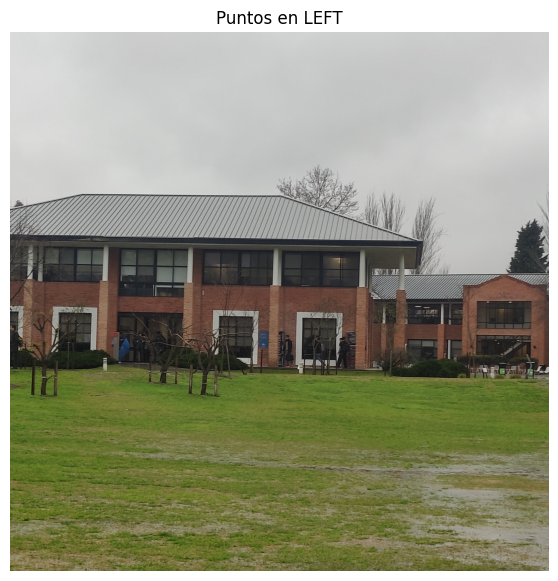

In [6]:
import numpy as np

def _normalize_points(pts):
    """
    Normaliza puntos 2D (Hartley): centra en el centroid y escala para que
    la distancia promedio al origen sea sqrt(2).

    Parámetros:
      - pts: ndarray (N x 2)

    Returns:
      - pts_n: ndarray (N x 2) puntos normalizados
      - T: ndarray (3 x 3) matriz de normalización tal que x_n = T @ x
    """
    pts = np.asarray(pts, dtype=np.float64)
    assert pts.ndim == 2 and pts.shape[1] == 2, "Esperaba (N,2)"
    centroid = pts.mean(axis=0)
    shifted = pts - centroid
    d = np.sqrt((shifted**2).sum(axis=1)).mean()
    s = np.sqrt(2) / d if d > 0 else 1.0
    T = np.array([[s, 0, -s*centroid[0]],
                  [0, s, -s*centroid[1]],
                  [0, 0, 1]], dtype=np.float64)
    pts_h = np.c_[pts, np.ones(len(pts))]
    pts_n_h = (T @ pts_h.T).T
    return pts_n_h[:, :2], T

def _build_A(src, dst):
    """
    Construye la matriz A del DLT para correspondencias src->dst.
    src = (x, y) ; dst = (u, v)
    """
    n = src.shape[0]
    A = np.zeros((2*n, 9), dtype=np.float64)
    x, y = src[:,0], src[:,1]
    u, v = dst[:,0], dst[:,1]

    # Forma clásica:
    # [ x y 1  0 0 0  -u*x -u*y -u ]
    # [ 0 0 0  x y 1  -v*x -v*y -v ]
    A[0::2, 0:3] = np.c_[x, y, np.ones(n)]
    A[1::2, 3:6] = np.c_[x, y, np.ones(n)]
    A[0::2, 6:9] = -np.c_[u*x, u*y, u]
    A[1::2, 6:9] = -np.c_[v*x, v*y, v]
    return A

def dlt_homography(pts_src, pts_dst, normalize=True):
    """
    Calcula la homografía H que lleva pts_src -> pts_dst usando DLT (sin OpenCV).

    Parámetros:
      - pts_src: ndarray (N x 2) puntos en la imagen fuente
      - pts_dst: ndarray (N x 2) puntos correspondientes en la imagen destino (ancla)
      - normalize: si True, usa normalización de Hartley

    Returns:
      - H: ndarray (3 x 3) homografía tal que x' ~ H @ x
    """
    src = np.asarray(pts_src, dtype=np.float64)
    dst = np.asarray(pts_dst, dtype=np.float64)
    assert src.shape == dst.shape and src.shape[0] >= 4, "Se necesitan N≥4 pares"

    if normalize:
        src_n, T_src = _normalize_points(src)
        dst_n, T_dst = _normalize_points(dst)
    else:
        src_n, dst_n = src, dst
        T_src = T_dst = np.eye(3)

    A = _build_A(src_n, dst_n)

    # Resolver Ah = 0 por SVD: h = último vector singular (columna de V) o fila de V^T
    U, S, Vt = np.linalg.svd(A)
    h = Vt[-1, :]
    Hn = h.reshape(3, 3)

    # Des-normalizar: H = T_dst^{-1} * Hn * T_src
    H = np.linalg.inv(T_dst) @ Hn @ T_src

    # Escalar para que H[2,2] = 1 (si no es ~0)
    if abs(H[2,2]) > 1e-12:
        H = H / H[2,2]
    return H

def reproject_points(H, pts_src):
    """
    Aplica H a pts_src (N x 2) y devuelve puntos reproyectados (N x 2) en el destino.
    """
    pts = np.asarray(pts_src, dtype=np.float64)
    pts_h = np.c_[pts, np.ones(len(pts))].T   # (3 x N)
    proj = H @ pts_h                           # (3 x N)
    proj = (proj[:2] / proj[2]).T              # (N x 2)
    return proj

def rmse_reproj(H, pts_src, pts_dst):
    """
    RMSE de reproyección entre H*pts_src y pts_dst (en píxeles).
    """
    pred = reproject_points(H, pts_src)
    err = np.linalg.norm(pred - np.asarray(pts_dst, dtype=np.float64), axis=1)
    return float(np.sqrt(np.mean(err**2))), err

import matplotlib.pyplot as plt

def pick_points(img_rgb, n=4, title="Elegí puntos (click izq)"):
    """
    Permite seleccionar 'n' puntos sobre la imagen (en orden).
    Devuelve ndarray (n x 2).
    """
    fig, ax = plt.subplots(figsize=(7,7))
    ax.imshow((img_rgb*255).astype(np.uint8) if img_rgb.dtype!=np.uint8 else img_rgb)
    ax.set_title(title); ax.axis('off')
    pts = plt.ginput(n, timeout=0)  # click izquierdo para marcar, derecho para deshacer último
    plt.close(fig)
    return np.array(pts, dtype=np.float64)

# Ejemplo:
ptsL = pick_points(udesa_left,  n=4, title="Puntos en LEFT")
ptsC_fromL = pick_points(udesa_center, n=4, title="Correspondientes en CENTER")
